# Network construction

Network construction is aligned with the questions we aim to answer in the project. For this, the nodes represent the deputies. Two deputies are linked if their voting pattern is similar, which will be made clear below. 

We consider the votings that occurred during a period (year or legislature) in the plenary. 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from DadosAbertosBrasil import camara

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time
from tqdm.notebook import trange, tqdm
import requests

api = "https://dadosabertos.camara.leg.br/api/v2/"
dados = "http://dadosabertos.camara.leg.br/arquivos/"

### Importing the votings

Let's see how the importing occur. 

In [2]:
votings = pd.read_csv('../data/tables/votes_info.csv')
votings_plen = votings[votings.siglaOrgao=='PLEN']

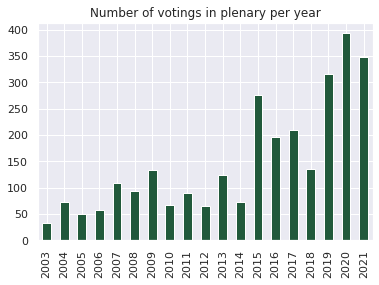

In [3]:
votings_plen.year.value_counts().sort_index().plot.bar(color='#21593b')
plt.title('Number of votings in plenary per year')
plt.show()

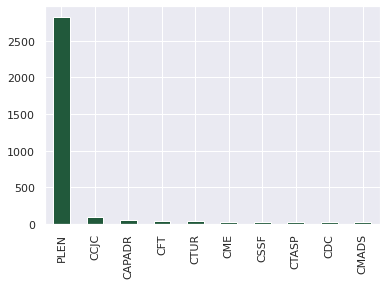

In [4]:
votings.siglaOrgao.value_counts().iloc[0:10].plot.bar(color='#21593b')
plt.show()

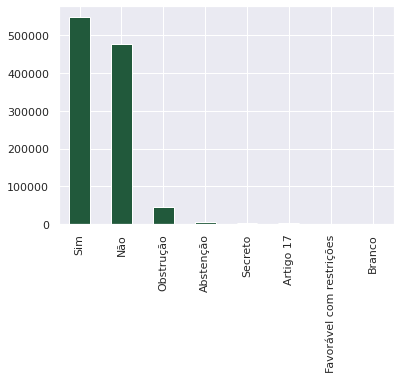

In [5]:
votings_deputies = pd.read_csv('../data/tables/votes_deputies.csv')
votings_deputies.voto.value_counts().plot.bar(color='#21593b')
plt.show()

In [6]:
deputies = pd.read_csv('../data/tables/deputies.csv', index_col = 0)

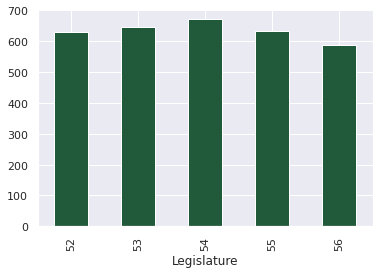

In [7]:
deputies.idLegislatura.value_counts().sort_index().plot.bar(color='#21593b')
plt.xlabel('Legislature')
plt.show()